<a href="https://colab.research.google.com/github/yemikifouly/dog-breeds-classifier/blob/master/dog_breeds_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classifying Dog Breeds

The goal of this project is to identify the breeds of dogs given their images. Besides doing this, the notebook also contains contain for the cases where the images given the model are images of a human being. In which case the code is supposed to return the dog breed the human most closely resembles.

In [0]:
# import statements
from tqdm import tqdm

import os

import numpy as np

from glob import glob

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models

from PIL import Image
import torchvision.transforms as transforms
# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline
import matplotlib.pyplot as plt

import random

import re

In [4]:
use_cuda = torch.cuda.is_available()
print('Using gpu...' if use_cuda else 'Using cpu...')

Using gpu...


## Step 0: Loading the data

Loading and unzipping the data.

In [0]:
!wget -q 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip'

In [0]:
!unzip dogImages.zip

## Step 1: Checking content of the files


Check the content of the loaded folders.

In [7]:
# load filenames for human and dog images
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


In [0]:
def retrieve_name(img_path):
    pattern = r'.+/(\w+)_\d+.jpg'
    match = re.findall(pattern, img_path, re.I)[0]
    match = match.replace('_', ' ').title()
    return match

In [0]:
def display_image(img_path):
    img = Image.open(img_path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    title = retrieve_name(img_path)
    plt.title(title)

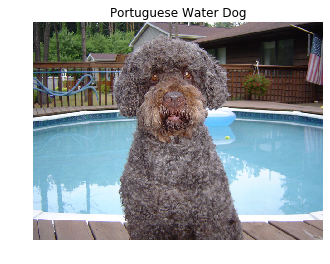

In [10]:
display_image(random.choice(dog_files))

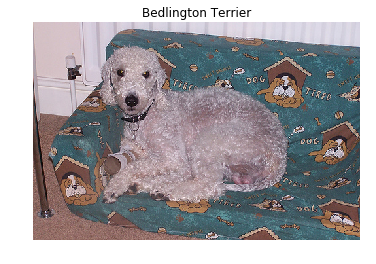

In [11]:
display_image(random.choice(dog_files))

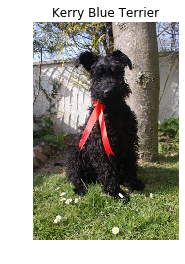

In [12]:
display_image(random.choice(dog_files))

###1.b: Preprocessing the images

In [0]:
def preprocess_img(image):
    normalize = transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
    
    preprocess = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize
                 ])
    
    return preprocess(image)

## Define Dataloaders

In [0]:
batch_size, num_workers = 20, 0

train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])
                                      ])

valid_and_test_transforms = transforms.Compose([transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                                     [0.229, 0.224, 0.225])
                                               ])

# Get the data folders
train_data = datasets.ImageFolder('dogImages/train', transform=train_transforms)

valid_data = datasets.ImageFolder('dogImages/valid', 
                                      transform=valid_and_test_transforms)

test_data = datasets.ImageFolder('dogImages/test', 
                                      transform=valid_and_test_transforms)

data_dict = {'train':train_data,
             'valid':valid_data,
             'test':test_data}

# Define the loaders
loaders = {name:torch.utils.data.DataLoader(folder, batch_size=batch_size,
                shuffle=True, num_workers=num_workers) for name, folder in data_dict.items()}

In [15]:
num_classes = len(train_data.classes)
num_classes

133

In [0]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    
    if use_cuda:
        model = model.cuda()
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()        
            optimizer.zero_grad()
            output = model.forward(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            ## find the loss and update the model parameters accordingly
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - 
                                                                train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model.forward(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - 
                                                                valid_loss))

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). \
            Saving model ...'.format (valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

## Transfer Learning

In [17]:
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 118355106.52it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [18]:
fc = nn.Sequential(nn.Linear(2048, 1000),
                   nn.ReLU(inplace=True),
                   nn.Dropout(0.5),
                   nn.Linear(1000, 256),
                   nn.ReLU(inplace=True),
                   nn.Dropout(0.5),
                   nn.Linear(256, num_classes))
fc

Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=1000, out_features=256, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=256, out_features=133, bias=True)
)

In [19]:
model.fc = fc
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
criterion = nn.CrossEntropyLoss()

for param in model.layer4.parameters() or param in model.fc.parameters():
    param.requires_grad = True
else:
    param.requires_grad = False

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [21]:
start = time.time()

# train the model
model = train(60, loaders, model, optimizer, criterion, use_cuda, 'model.pt')
end = time.time()
elapsed_time = end - start
print('Time elapsed:{:.1f}min {:.1f}sec'.format(elapsed_time//60, elapsed_time%60))

# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model.pt'))

Epoch: 1 	Training Loss: 4.754922 	Validation Loss: 4.459303
Validation loss decreased (inf --> 4.459303).             Saving model ...
Epoch: 2 	Training Loss: 4.505916 	Validation Loss: 4.124497
Validation loss decreased (4.459303 --> 4.124497).             Saving model ...
Epoch: 3 	Training Loss: 4.335029 	Validation Loss: 3.876609
Validation loss decreased (4.124497 --> 3.876609).             Saving model ...
Epoch: 4 	Training Loss: 4.180241 	Validation Loss: 3.738021
Validation loss decreased (3.876609 --> 3.738021).             Saving model ...
Epoch: 5 	Training Loss: 4.039838 	Validation Loss: 3.551064
Validation loss decreased (3.738021 --> 3.551064).             Saving model ...
Epoch: 6 	Training Loss: 3.919982 	Validation Loss: 3.376866
Validation loss decreased (3.551064 --> 3.376866).             Saving model ...
Epoch: 7 	Training Loss: 3.793437 	Validation Loss: 3.331455
Validation loss decreased (3.376866 --> 3.331455).             Saving model ...
Epoch: 8 	Training

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total)) 


In [23]:
test(loaders, model, criterion, use_cuda)

Test Loss: 0.943016


Test Accuracy: 85% (718/836)
